In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from collections import deque
import matplotlib.pyplot as plt
import glfw

observation = val_env.step(val_env.action_space.sample())[0]

reward = val_env.step(val_env.action_space.sample())[1]

terminated = val_env.step(val_env.action_space.sample())[2] # bool

truncated = val_env.step(val_env.action_space.sample())[3] # bool

info = val_env.step(val_env.action_space.sample())[4] # dict

dict_keys(['reward_linvel', 'reward_quadctrl', 'reward_alive', 'x_position', 'y_position', 'distance_from_origin', 'x_velocity', 'y_velocity', 'forward_reward'])

### Actor

In [110]:
class Actor(nn.Module) :
    def __init__(self, input_size, hidden_size, n_actions, min_act_value, lr, device=torch.device('cpu')):
        super(Actor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_actions = n_actions
        self.min_act_value = min_act_value
        self.lr = lr
        self.device = device

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.fc1 = nn.Linear(
            in_features=self.input_size,
            out_features=self.hidden_size
        )

        self.fc2 = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.hidden_size
        )

        self.mean_fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features=self.n_actions
        )

        torch.nn.init.kaiming_normal_(self.mean_fc3.weight)

        self.log_std_fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features=self.n_actions
        )

        torch.nn.init.kaiming_normal_(self.log_std_fc3.weight)

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.lr)

    def forward(self, x):

        x = x.float() # from float64 to float32

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))

        mean = self.mean_fc3(x)

        clamped_log_std = torch.clamp(self.log_std_fc3(x), -20, 2) # clamp the log_std

        return mean, clamped_log_std   # mean, log_std
    
    def act(self, state, greedy=False):
        mean, log_std = self.forward(state)
        #   print('Mean: ', mean)
        #   print('Log_Std: ', log_std)

        action = self.tanh(mean)

        log_prob = None

        if not greedy: # explore
            
            # Apply Reparameterization Trick
            gaussian = Normal(0, 1)
            z = gaussian.sample()
            std = (log_std).exp()
            action = self.tanh(mean + std*z)
            
            log_prob = Normal(mean, std).log_prob(mean + std*z.to(self.device)+ 1e-6)
        
        return action, log_prob


### Critic

In [111]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, lr, device=torch.device('cpu')):
        super(Critic, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.device = device

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(
            in_features=self.input_size,
            out_features=self.hidden_size
        )

        self.fc2 = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.hidden_size
        )

        self.fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features= 1
        )

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        self.criterion = nn.MSELoss()

    def forward(self, x):

        x = x.float() # from float64 to float32

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))

        return self.fc3(x)

In [108]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action



### Algorithm

In [137]:
class Actor_Critic(nn.Module):
    def __init__(self, input_size, hidden_size, n_actions, min_act_value, act_lr, crt_lr, num_episodes, gamma, device=torch.device('cpu')):
        super(Actor_Critic, self).__init__()
        self.device = device

        self.num_episodes = num_episodes
        self.gamma = gamma

        self.Actor = Actor(
            input_size= input_size,
            hidden_size= hidden_size,
            n_actions= n_actions,
            min_act_value= min_act_value,
            lr= act_lr,
            device= self.device
        )

        self.Critic = Critic(
            input_size= input_size,
            hidden_size= hidden_size,
            lr= crt_lr,
            device= self.device
        )

        self.scheduler_actor_lr = optim.lr_scheduler.ReduceLROnPlateau(self.Actor.optimizer, factor=0.99, mode='min', patience=150, verbose=True)
        self.scheduler_critic_lr = optim.lr_scheduler.ReduceLROnPlateau(self.Critic.optimizer, factor=0.99, mode='min', patience=150, verbose=True)

    def save(self, model_name):
        torch.save(self.state_dict(), model_name + '.pt')

    def load(self, model_name):
        self.load_state_dict(torch.load(model_name + '.pt', map_location=self.device))

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret

    def train(self):

        E = NormalizedActions(gym.make(
            id='Humanoid-v4',            
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        ))
        

        scores = deque()
        scores_500 = deque(maxlen=500)
        act_losses = deque()
        crt_losses = deque()

        for iter in range(self.num_episodes):

        # CONTAINERS

            Rewards = []
            Log_prob = []
            Values = []
            obs_next = E.reset()[0]
            done_next = False

        # ROLLOUT
            t = 0

            while not done_next:

            #obs = torch.from_numpy(obs_next)
            #done = done_next

                action, log_prob = self.Actor.act(torch.from_numpy(obs_next))

                # print(action)

                obs_next, reward, terminated, truncated, info = E.step(action.detach().numpy())

                value = self.Critic.forward(torch.from_numpy(obs_next))
                
                Log_prob.append(log_prob)
                Values.append(value)
                Rewards.append(reward)

                done_next = terminated or truncated

                t+=1 # update counter

            scores.append(sum(Rewards))
            scores_500.append(sum(Rewards))

            #   print('Mean Score: ',np.mean(scores))

        # LEARNING

            #print(Log_prob)
            #print(t)

            Log_prob = torch.stack(Log_prob)
            # print(Log_prob.shape)
            Values = torch.stack(Values).squeeze()

            # compute Advantage
            Vnext = self.Critic.forward(torch.from_numpy(obs_next)).squeeze()
            # print(Vnext)
            Advantage = torch.zeros(t)
            Return = torch.zeros(t)

            for a in reversed(range(t)):
                if a == t-1:
                    Return[a] = Rewards[a] + self.gamma*Vnext
                else:
                    Return[a] = Rewards[a] + self.gamma*Values[a+1]
                    
            Advantage = Return - Values
            
            # policy gradient
            actor_loss = (- Log_prob.T @ Advantage.detach()).mean()

            #   natural gradient = F^-1 * policy gradient
            #   F = self.Fisher_Info_matrix(Log_prob)
            #   print(F.shape)
            #   natural_gradient = torch.inverse(F) * actor_loss

            critic_loss = self.Critic.criterion(Values, Advantage)

            act_losses.append(actor_loss.item())
            #   print('Actor Loss: ', actor_loss)
            crt_losses.append(critic_loss.item())
            #   print('Critic Loss: ', critic_loss)

        # UPDATES

            # Actor
            self.Actor.optimizer.zero_grad()
            actor_loss.backward()
            self.Actor.optimizer.step()
            self.scheduler_actor_lr.step(actor_loss)

            # Critic
            self.Critic.optimizer.zero_grad()
            critic_loss.backward()
            self.Critic.optimizer.step()
            self.scheduler_critic_lr.step(critic_loss)

        # SAVE


            if iter % 500 == 0:

                print(f'''Episode {iter}
                    \tAverage Score: {np.mean(scores_500)}
                    \tAverage Actor Loss: {np.mean(act_losses)}
                    \tAverage Critic Loss: {np.mean(crt_losses)}
                    \tLast Score: {sum(Rewards)}\n''')
                
            if iter % 5000 == 0:
                model_name = 'model_' + str((iter % self.num_episodes) // 5000)
                self.save(model_name)

        return act_losses, crt_losses, scores

### Evaluation

In [130]:
def Evaluate_Humanoid(agent, n_eval_episodes):
    rewards = []

    agent.load('final')

    val_env = NormalizedActions(gym.make(
        id='Humanoid-v4',
        terminate_when_unhealthy = True,
        exclude_current_positions_from_observation=False,
        render_mode = 'human',
    ))

    for n_episode in range(n_eval_episodes):
        episode_rewards = 0
        obs = val_env.reset()[0]
        done = False

        while not done:
            
            action, _ = agent.Actor.act(torch.from_numpy(obs), greedy=True)
            # print(action)
            # action = torch.sqrt(action+0.4) - 0.4
            #print(action)
            obs_next, rew, terminated, truncated, info = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            episode_rewards += rew
            obs = obs_next

        print('Reward episode %d: %d' %(n_episode, episode_rewards))

        rewards.append(episode_rewards)

    print('Mean Reward: ', np.mean(rewards))
    glfw.terminate() # close Mujoco render

In [122]:
def Previous_Episodes(agent):

    val_env = NormalizedActions(gym.make(
        id='Humanoid-v4',
        terminate_when_unhealthy = True,
        exclude_current_positions_from_observation=False,
        render_mode = 'human',
    ))
    num = agent.num_episodes // 5000  # change this value in order to have 3/4 previous model 
    print(num)
    for n_model in range(num):
        agent.load('model_'+str(n_model))

        episode_rewards = 0
        obs = val_env.reset()[0]
        done = False

        while not done:
            
            action, _ = agent.Actor.act(torch.from_numpy(obs), greedy=True)
            #print(action)
            obs_next, rew, terminated, truncated, info = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            episode_rewards += rew
            obs = obs_next

        print('Reward at %d: %d' %(n_model*5000, episode_rewards))
        
    glfw.terminate() # close Mujoco render

### Training and Testing

In [138]:
agent = Actor_Critic(
    input_size= 378,
    hidden_size= 32,
    n_actions= 17,
    min_act_value= 4e-1,
    act_lr= 1e-2,
    crt_lr= 1e-2,
    num_episodes= 40000,
    gamma=0.9
)

act_losses, crt_losses, scores_rew = agent.train()
agent.save('final')

Episode 0
                    	Average Score: 113.87156244762686
                    	Average Actor Loss: 704104.375
                    	Average Critic Loss: 182.0963134765625
                    	Last Score: 113.87156244762686

Epoch 00172: reducing learning rate of group 0 to 9.9000e-03.
Epoch 00323: reducing learning rate of group 0 to 9.8010e-03.
Epoch 00474: reducing learning rate of group 0 to 9.7030e-03.
Episode 500
                    	Average Score: 110.57540388760933
                    	Average Actor Loss: 61237.03537822198
                    	Average Critic Loss: 4.696438557760207
                    	Last Score: 105.13258011047789

Epoch 00625: reducing learning rate of group 0 to 9.6060e-03.
Epoch 00685: reducing learning rate of group 0 to 9.9000e-03.
Epoch 00776: reducing learning rate of group 0 to 9.5099e-03.
Epoch 00927: reducing learning rate of group 0 to 9.4148e-03.
Epoch 00953: reducing learning rate of group 0 to 9.8010e-03.
Episode 1000
                    	A

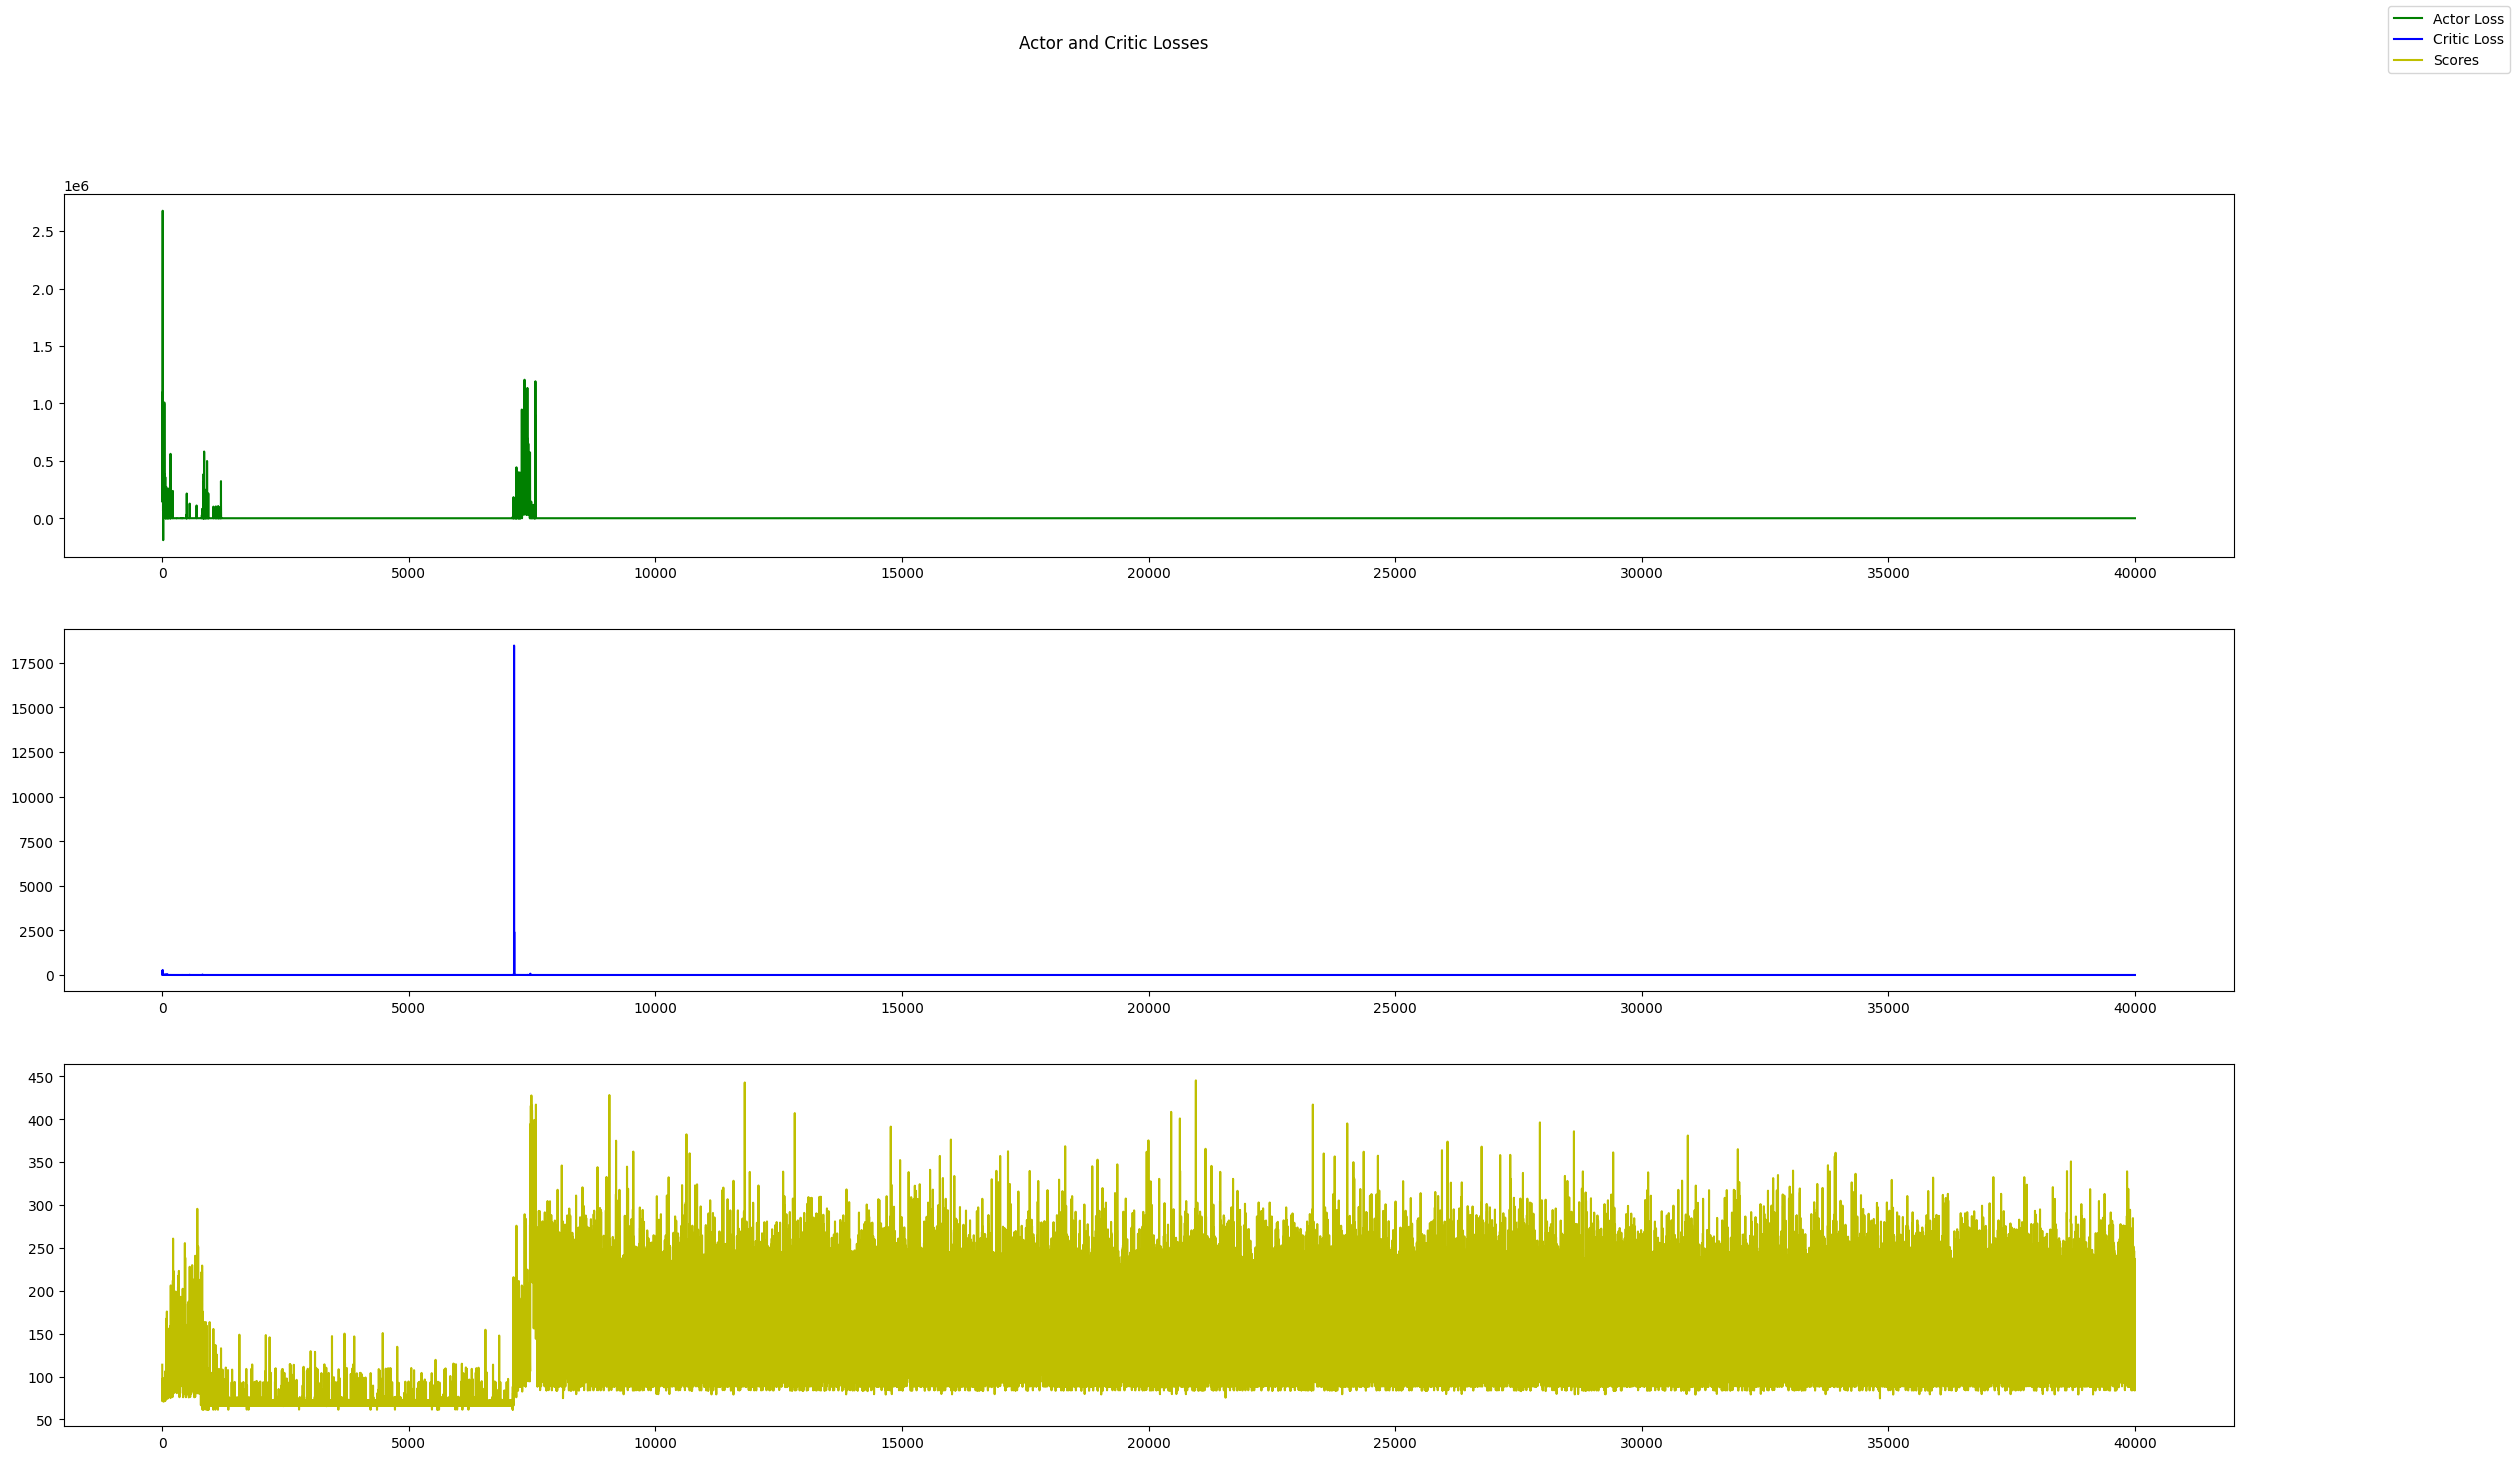

In [139]:
episodes = np.arange(1, agent.num_episodes + 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Actor and Critic Losses')

ax1.plot(episodes, act_losses, 'g', label='Actor Loss')

ax2.plot(episodes, crt_losses, 'b', label='Critic Loss')

ax3.plot(episodes, scores_rew, 'y', label='Scores')

fig.legend()
fig.set_figwidth(28)
fig.set_figheight(16)

In [142]:
Evaluate_Humanoid(agent, 10)

Reward episode 0: 205
Reward episode 1: 194
Reward episode 2: 211
Reward episode 3: 216
Reward episode 4: 211
Reward episode 5: 211
Reward episode 6: 193
Reward episode 7: 202
Reward episode 8: 201
Reward episode 9: 113
Mean Reward:  196.28382345893647


In [141]:
Previous_Episodes(agent)

8
Reward at 0: 96
Reward at 5000: 66
Reward at 10000: 178
Reward at 15000: 190
Reward at 20000: 193
Reward at 25000: 122
Reward at 30000: 170
Reward at 35000: 107
